In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import glob
import networkx as nx

from plotnine import *
from mizani.formatters import percent_format, date_format, scientific_format
from mizani.breaks import date_breaks

data_dir = '/Users/zhicong/Dropbox/DEXs'
pool_name = 'USDC-WETH'

# Load Data

We first load the token price data.

In [2]:
price_data = pd.read_csv(os.path.join(data_dir, 'token_prices', 'WETH.csv'))
price_data['month'] = pd.to_datetime(price_data['hour']).dt.tz_localize(None).dt.to_period('M').dt.to_timestamp() 
price_volatility = price_data.groupby(['month']).agg({'price':np.std}).reset_index()

price_volatility.head()

,month,price
0,2020-05-01,11.412330
1,2020-06-01,6.667416
2,2020-07-01,36.288497
3,2020-08-01,18.249977
4,2020-09-01,31.207953


We also want to load the liquidity provision data.

In [3]:
lp_action = pd.DataFrame(columns = ['POOL_NAME', 'EVENT_NAME', 'BLOCK_NUMBER', 'BLOCK_TIMESTAMP', 'SENDER', 'NF_TOKEN_ID', 'AMOUNT0_ADJUSTED', 'TOKEN0_SYMBOL', 'AMOUNT0_USD',
                                    'AMOUNT1_ADJUSTED', 'TOKEN1_SYMBOL', 'AMOUNT1_USD', 'TICK_LOWER', 'TICK_UPPER', 'PRICE_LOWER', 'PRICE_UPPER', 'L'])

for file_name in [file for file in glob.glob(os.path.join(data_dir, "uniswapv3_lp_action_LP") + '/*.csv') if pool_name in file]:

    lp_action = pd.concat([lp_action, pd.read_csv(file_name).drop(columns = 'TX_HASH')])

# Final cleaning
lp_action['BLOCK_TIMESTAMP'] = pd.to_datetime(lp_action['BLOCK_TIMESTAMP'])
lp_action['AMOUNT0_ADJUSTED'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT0_ADJUSTED'], lp_action['AMOUNT0_ADJUSTED'])
lp_action['AMOUNT0_USD'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT0_USD'], lp_action['AMOUNT0_USD'])
lp_action['AMOUNT1_ADJUSTED'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT1_ADJUSTED'], lp_action['AMOUNT1_ADJUSTED'])
lp_action['AMOUNT1_USD'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['AMOUNT1_USD'], lp_action['AMOUNT1_USD'])
lp_action['L'] = np.where(lp_action['EVENT_NAME'] == 'Decrease Liquidity', -lp_action['L'], lp_action['L'])

# Remove observations without NF_TOKRN_ID
lp_action.dropna(subset = ['NF_TOKEN_ID'], inplace = True)
lp_action['NF_TOKEN_ID'] = lp_action['NF_TOKEN_ID'].apply(str).str.replace('.0','', regex = False)

# Round Liquidity Parameter to 5 decimal point
lp_action['L'] = round(lp_action['L'], 5)

lp_action.reset_index(drop = True, inplace = True)
lp_action.head()

,POOL_NAME,EVENT_NAME,BLOCK_NUMBER,BLOCK_TIMESTAMP,SENDER,NF_TOKEN_ID,AMOUNT0_ADJUSTED,TOKEN0_SYMBOL,AMOUNT0_USD,AMOUNT1_ADJUSTED,TOKEN1_SYMBOL,AMOUNT1_USD,TICK_LOWER,TICK_UPPER,PRICE_LOWER,PRICE_UPPER,L
0,USDC-WETH 3000 60,Increase Liquidity,12370624,2021-05-04 23:10:00,0x3b8ccaa89fcd432f1334d35b10ff8547001ce3e5,37,0.000000,USDC,0.000000,0.010000,WETH,33.542413,192180,193380,3999.753253,4509.682144,10.86051
1,USDC-WETH 3000 60,Increase Liquidity,12370671,2021-05-04 23:19:42,0xe14722b5f1aa6ea161e547c5ca598068ec1b3bc0,38,50000.000000,USDC,49997.486569,9.205484,WETH,30877.415059,192660,199800,2104.893286,4298.340735,4303.36967
2,USDC-WETH 3000 60,Increase Liquidity,12371434,2021-05-05 02:10:21,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,41,167.505955,USDC,167.501413,0.044750,WETH,150.584382,195060,195540,3222.777198,3381.235151,229.98572
3,USDC-WETH 3000 60,Increase Liquidity,12371483,2021-05-05 02:21:03,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,41,0.010000,USDC,0.010000,0.000003,WETH,0.008990,195060,195540,3222.777198,3381.235151,0.01373
4,USDC-WETH 3000 60,Decrease Liquidity,12371521,2021-05-05 02:30:25,0x5eefc9306f11a824762ccdaedac41049efc7fcc8,41,-167.515954,USDC,-167.511412,-0.044752,WETH,-150.593372,195060,195540,3222.777198,3381.235151,-229.99945


For the same token, we want to change them to the same address (the mint recepient address).

In [4]:
address_cluster = lp_action[['POOL_NAME','NF_TOKEN_ID','SENDER']].copy()
address_cluster['unique_address'] = address_cluster.groupby(['POOL_NAME','NF_TOKEN_ID'])['SENDER'].transform('nunique')
address_cluster = address_cluster[address_cluster['unique_address'] > 1]
address_cluster.drop_duplicates(inplace = True)

address_cluster = address_cluster.groupby(['POOL_NAME','NF_TOKEN_ID'])['SENDER'].apply(list).reset_index()
address_cluster = address_cluster['SENDER']

# Concat lists if they share common element
G = nx.Graph()
for l in address_cluster:
    G.add_edges_from(nx.utils.pairwise(l))
connected_components = list(nx.connected_components(G))
address_cluster = pd.DataFrame({'SENDER':[list(comp) for comp in connected_components]})

# Take one address as the shared address for all lists
address_cluster['ADDRESS'] = address_cluster['SENDER'].str[0]
address_cluster = address_cluster.explode('SENDER', ignore_index = True)
address_cluster = address_cluster[['ADDRESS','SENDER']].set_index('SENDER').to_dict()['ADDRESS']

lp_action['SENDER'] = lp_action['SENDER'].replace(address_cluster)

# Identifying liquidity reallocation 

Since liquidity allocation depends on risk-aversion of the liquidity provider, we want to identify events of liquidity reallocation which can signal when a liquidity provider changes their risk aversion.

## Across multiple fee pools

First, to compare pools of different fees, we need to change POOL_NAME into a categorical variable where the pool "USDC-WETH 100 1" will be larger than "USDC-WETH 3000 60". Then, we filter for LP actions of LPs that have provided liquidity in multiple pools.

In [5]:
lp_action['POOL_NAME'] = pd.Categorical(lp_action['POOL_NAME'], categories = [pool_name + fees for fees in [' 3000 60',' 500 10',' 100 1']], ordered = True)

multi_pool_LPs = lp_action.groupby(['SENDER'])['POOL_NAME'].nunique().reset_index()
multi_pool_LPs = multi_pool_LPs[multi_pool_LPs['POOL_NAME'] >= 2]['SENDER']

multi_pool_lp_action = lp_action[lp_action['SENDER'].isin(multi_pool_LPs)]
# We want to also sort by EVENT_NAME because within the same block, we want the event Decrease Liquidity to come first
multi_pool_lp_action = multi_pool_lp_action.sort_values(by = ['SENDER','BLOCK_NUMBER','POOL_NAME','EVENT_NAME'])
multi_pool_lp_action.reset_index(drop = True, inplace = True)

multi_pool_LPs.head()

1     0x00000000002108f4085d2fd429669ce8f9851241
8     0x0000c3caa36e2d9a8cd5269c976ede05018f0000
19    0x0008d343091ef8bd3efa730f6aae5a26a285c7a2
21    0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d
25    0x000ef2b60d565ac16d06ff791129055e591b631e
Name: SENDER, dtype: object

We define LP reallocation across pools based on multiple conditions:

- The same address withdrew liquidity in one pool then provided liquidity in another pool of different fees.

- The two action is done within 1 hour.

- There is no liquidity provision action of the same amount of liquidity in the same block of the liquidity withdrawal action (liquidity arbitrage).

In [6]:
multi_pool_lp_action['time_diff'] = multi_pool_lp_action.groupby(['SENDER'])['BLOCK_TIMESTAMP'].diff()

liquidity_reallocation = pd.DataFrame()

for i in range(len(multi_pool_lp_action)-1):
    
    if (multi_pool_lp_action.loc[i,'EVENT_NAME'] == 'Decrease Liquidity') & (multi_pool_lp_action.loc[i+1,'EVENT_NAME'] == 'Increase Liquidity') &\
       (multi_pool_lp_action.loc[i,'POOL_NAME'] != multi_pool_lp_action.loc[i+1,'POOL_NAME']) &\
       (multi_pool_lp_action.loc[i+1,'time_diff'] <= dt.timedelta(hours = 1)):

        new_row = {'SENDER':multi_pool_lp_action.loc[i,'SENDER'], 
                   'Decreased Liquidity Pool':multi_pool_lp_action.loc[i,'POOL_NAME'], 
                   'Decreased Liquidity Block Number':multi_pool_lp_action.loc[i,'BLOCK_NUMBER'], 'Decreased Liquidity Timestamp':multi_pool_lp_action.loc[i,'BLOCK_TIMESTAMP'],
                   'Decreased Liquidity Token0 Amount':multi_pool_lp_action.loc[i,'AMOUNT0_ADJUSTED'], 'Decreased Liquidity Token1 Amount':multi_pool_lp_action.loc[i,'AMOUNT1_ADJUSTED'],
                   'Decreased Liquidity Token0 USD':multi_pool_lp_action.loc[i,'AMOUNT0_USD'], 'Decreased Liquidity Token1 USD':multi_pool_lp_action.loc[i,'AMOUNT1_USD'],
                   'Decreased Liquidity Price Lower':multi_pool_lp_action.loc[i,'PRICE_LOWER'], 'Decreased Liquidity Price Upper':multi_pool_lp_action.loc[i,'PRICE_UPPER'],
                   'Increased Liquidity Pool':multi_pool_lp_action.loc[i+1,'POOL_NAME'], 
                   'Increased Liquidity Block Number':multi_pool_lp_action.loc[i+1,'BLOCK_NUMBER'], 'Increased Liquidity Timestamp':multi_pool_lp_action.loc[i+1,'BLOCK_TIMESTAMP'],
                   'Increased Liquidity Token0 Amount':multi_pool_lp_action.loc[i+1,'AMOUNT0_ADJUSTED'], 'Increased Liquidity Token1 Amount':multi_pool_lp_action.loc[i+1,'AMOUNT1_ADJUSTED'],
                   'Increased Liquidity Token0 USD':multi_pool_lp_action.loc[i+1,'AMOUNT0_USD'], 'Increased Liquidity Token1 USD':multi_pool_lp_action.loc[i+1,'AMOUNT1_USD'],
                   'Increased Liquidity Price Lower':multi_pool_lp_action.loc[i+1,'PRICE_LOWER'], 'Increased Liquidity Price Upper':multi_pool_lp_action.loc[i+1,'PRICE_UPPER']}
        
        
        liquidity_reallocation = pd.concat([liquidity_reallocation, pd.DataFrame([new_row])], ignore_index = True)

liquidity_reallocation['month'] = pd.to_datetime(liquidity_reallocation['Decreased Liquidity Timestamp']).dt.to_period('M').dt.to_timestamp()

liquidity_reallocation.head(5)

,SENDER,Decreased Liquidity Pool,Decreased Liquidity Block Number,Decreased Liquidity Timestamp,Decreased Liquidity Token0 Amount,Decreased Liquidity Token1 Amount,Decreased Liquidity Token0 USD,Decreased Liquidity Token1 USD,Decreased Liquidity Price Lower,Decreased Liquidity Price Upper,Increased Liquidity Pool,Increased Liquidity Block Number,Increased Liquidity Timestamp,Increased Liquidity Token0 Amount,Increased Liquidity Token1 Amount,Increased Liquidity Token0 USD,Increased Liquidity Token1 USD,Increased Liquidity Price Lower,Increased Liquidity Price Upper,month
0,0x00000000002108f4085d2fd429669ce8f9851241,USDC-WETH 3000 60,15518186,2022-09-12 01:37:06,-73.064052,-13.205754,-72.964100,-22955.694907,1747.653568,3999.753253,USDC-WETH 500 10,15518422,2022-09-12 02:32:53,0.000000,13.205776,0.000000,23048.833358,1770.520232,3999.753253,2022-09-01
1,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,USDC-WETH 500 10,15619810,2022-09-26 20:05:47,-12476.856493,-0.000000,-12476.856493,-0.000000,1280.549930,1320.866643,USDC-WETH 3000 60,15619838,2022-09-26 20:11:23,3001.700320,7.232869,3001.700320,9607.998411,1326.160425,1342.169412,2022-09-01
2,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,USDC-WETH 500 10,15826365,2022-10-25 16:43:59,-15134.375588,-0.000000,-15134.375588,-0.000000,1299.901989,1399.738130,USDC-WETH 3000 60,15826390,2022-10-25 16:48:59,5350.002794,6.901477,5350.002794,9733.222714,1391.365263,1451.044104,2022-10-01
3,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,USDC-WETH 3000 60,15412421,2022-08-26 01:13:28,-1370.879891,-1.222358,-1370.879891,-2057.582246,1550.038965,1889.420503,USDC-WETH 500 10,15412454,2022-08-26 01:21:03,1374.544513,1.224162,1374.544513,2060.619532,1553.141990,1898.890788,2022-08-01
4,0x0027a46efb18a6d72f113f8ebf4328ad65df22fa,USDC-WETH 500 10,12575211,2021-06-05 15:23:26,-2217.315387,-0.345136,-2217.315387,-913.023708,1863.154222,2966.099000,USDC-WETH 3000 60,12575240,2021-06-05 15:28:54,742.839874,0.358156,742.839874,947.466862,2208.386968,3222.777198,2021-06-01


In [7]:
"""
liquidity_reallocation = pd.DataFrame()

for i in range(len(multi_pool_lp_action)-1):

    # If there is a liquidity withdrawal action
    if (multi_pool_lp_action.loc[i,'EVENT_NAME'] == 'Decrease Liquidity'):

        liquidity_provider = multi_pool_lp_action.loc[i,'SENDER']
        start_time = multi_pool_lp_action.loc[i,'BLOCK_TIMESTAMP']
        end_time = multi_pool_lp_action.loc[i,'BLOCK_TIMESTAMP'] + dt.timedelta(hours = 1)
        original_pool = multi_pool_lp_action.loc[i,'POOL_NAME']
        original_block = multi_pool_lp_action.loc[i,'BLOCK_NUMBER']

        # Select all liquidity provision action before any further liquidity withdrawal action that are done by the same address, that is not made in the same pool, is within 1 hour of withdrawal
        #we do not need to worry about selecting same transaction multiple times as we filter for liquidity provision that happens before other withdrawal actions
        temp = multi_pool_lp_action[(multi_pool_lp_action['SENDER'] == liquidity_provider) &\
                                    (multi_pool_lp_action['BLOCK_TIMESTAMP'] >= start_time) & (multi_pool_lp_action['BLOCK_TIMESTAMP'] < end_time)]
        temp = temp.loc[temp.index.min():temp.index[temp['EVENT_NAME'] == 'Decrease Liquidity'].min()-1]
        temp = temp[temp['POOL_NAME'] != original_pool]
        
        if temp.empty:

            continue

        else:

            # Get information of liquidity withdrawal
            withdrawn_token0_usd = multi_pool_lp_action.loc[i,'AMOUNT0_USD']
            withdrawn_token1_usd = multi_pool_lp_action.loc[i,'AMOUNT1_USD']
            
            # Determine if the liquidity depositions are increase fee or decrease fee action
            temp['Increase or Decrease'] = np.where(temp['POOL_NAME'] > original_pool, 'Increase', 'Decrease')

            # Groupby Type of Action and sum
            temp = temp[['Increase or Decrease','AMOUNT0_USD','AMOUNT1_USD']].groupby(['Increase or Decrease']).agg({'Increase or Decrease':'count', 
                                                                                                                     'AMOUNT0_USD':np.sum, 
                                                                                                                     'AMOUNT1_USD':np.sum}).rename(columns = {'Increase or Decrease':'Count'}).reset_index()
            increase_info = temp[temp['Increase or Decrease'] == 'Increase']
            decrease_info = temp[temp['Increase or Decrease'] == 'Decrease']
            
            # Append new row to dataframe
            new_row = {'SENDER':liquidity_provider, 'Withdrawn Liquidity Timestamp': start_time, 'Withdrawn Liquidity Pool':original_pool, 'Withdrawn Token0 USD':withdrawn_token0_usd, 'Withdrawn Token1 USD':withdrawn_token1_usd}
            
            if not increase_info.empty:
                new_row['Increase Fee Count'] = increase_info.iloc[0]['Count']
                new_row['Increase Fee Token0 USD'] = increase_info.iloc[0]['AMOUNT0_USD']
                new_row['Increase Fee Token1 USD'] = increase_info.iloc[0]['AMOUNT1_USD']

            if not decrease_info.empty:
                new_row['Decrease Fee Count'] = decrease_info.iloc[0]['Count']
                new_row['Decrease Fee Token0 USD'] = decrease_info.iloc[0]['AMOUNT0_USD']
                new_row['Decrease Fee Token1 USD'] = decrease_info.iloc[0]['AMOUNT1_USD']

            liquidity_reallocation = pd.concat([liquidity_reallocation, pd.DataFrame([new_row])], ignore_index = True)

    else:

        continue


liquidity_reallocation['month'] = pd.to_datetime(liquidity_reallocation['Withdrawn Liquidity Timestamp']).dt.to_period('M').dt.to_timestamp()

liquidity_reallocation.to_csv(os.path.join(data_dir, 'FTX_case_study_data', 'USDC-WETH.csv'), index = False)
"""

"""
liquidity_reallocation = pd.read_csv(os.path.join(data_dir, 'FTX_case_study_data', 'USDC-WETH.csv'))
liquidity_reallocation['Withdrawn Liquidity Timestamp'] = pd.to_datetime(liquidity_reallocation['Withdrawn Liquidity Timestamp'], format = '%d/%m/%Y %H:%M')
liquidity_reallocation['month'] = pd.to_datetime(liquidity_reallocation['month'], format = '%d/%m/%Y')

liquidity_reallocation.head(5)
"""

"\nliquidity_reallocation = pd.read_csv(os.path.join(data_dir, 'FTX_case_study_data', 'USDC-WETH.csv'))\nliquidity_reallocation['Withdrawn Liquidity Timestamp'] = pd.to_datetime(liquidity_reallocation['Withdrawn Liquidity Timestamp'], format = '%d/%m/%Y %H:%M')\nliquidity_reallocation['month'] = pd.to_datetime(liquidity_reallocation['month'], format = '%d/%m/%Y')\n\nliquidity_reallocation.head(5)\n"

### By Number of Action

We are interested if there is a certain time period where many liquidity providers change their liquidity position.

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Number of liquidity reallocation action and price volatility


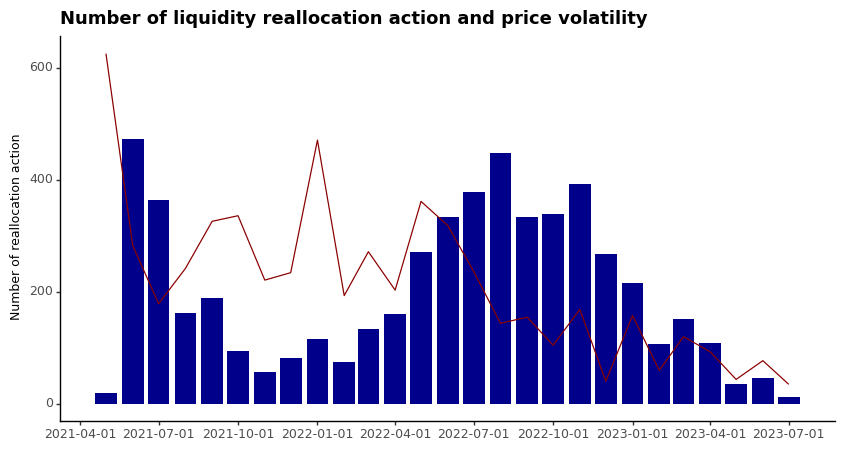

In [8]:
#liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month'])[['Increase Fee Count','Decrease Fee Count']].sum().sum(axis = 1).reset_index(name = 'count')
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month'])['SENDER'].count().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'SENDER'), fill = 'darkblue') + 
    geom_line(aes(y = 'price'), color = 'darkred') +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Number of liquidity reallocation action and price volatility',
         x = '', y = 'Number of reallocation action')
)

fig.save('./Plots/Number of liquidity reallocation action and price volatility', dpi = 1000)

print(fig)

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Number of unique liquidity provider that reallocated range of liquidity provision and price volatility.png


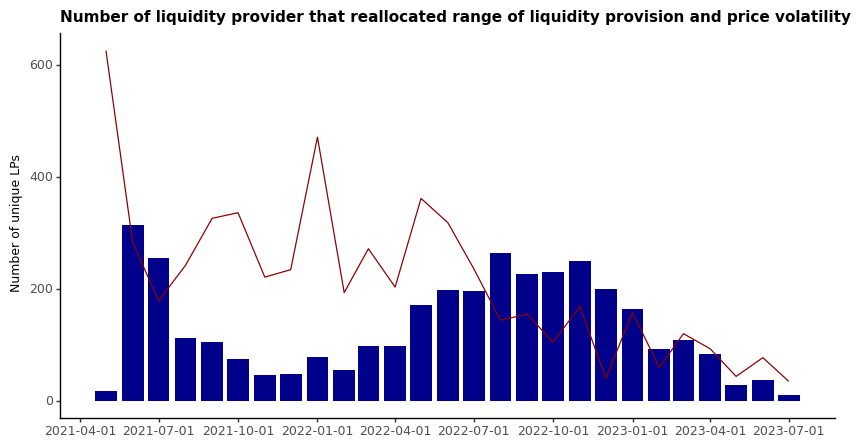

In [9]:
liquidity_reallocation_LP_by_month = liquidity_reallocation.groupby(['month'])['SENDER'].nunique().reset_index()
liquidity_reallocation_LP_by_month = liquidity_reallocation_LP_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_LP_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'SENDER'), fill = 'darkblue') + 
    geom_line(aes(y = 'price'), color = 'darkred') +
    
    theme_classic() +
    theme(plot_title = element_text(size = 11, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Number of liquidity provider that reallocated range of liquidity provision and price volatility',
         x = '', y = 'Number of unique LPs')
)

fig.save('./Plots/Number of unique liquidity provider that reallocated range of liquidity provision and price volatility.png', dpi = 1000)

print(fig)

It is very interesting to see that the time of peak liquidity reallocation is during August 2022 and November 2022.

Next, we want to seperate liquidity reallocation to 2 different situations:

- When liquidity provision moves from lower fees pool to higher fees pool

- When liquidity provision moves from higher fees pool to lower fees pool

In [10]:
liquidity_reallocation['Reallocation Action'] = np.where(((liquidity_reallocation['Decreased Liquidity Pool'] == 'USDC-WETH 3000 60') & (liquidity_reallocation['Increased Liquidity Pool'] == 'USDC-WETH 500 10')) |\
                                                         ((liquidity_reallocation['Decreased Liquidity Pool'] == 'USDC-WETH 500 10') & (liquidity_reallocation['Increased Liquidity Pool'] == 'USDC-WETH 100 1')),
                                                         'Increasing Fee Pool', 'Decreasing Fee Pool')

liquidity_reallocation[['SENDER','month','Reallocation Action']].head()

,SENDER,month,Reallocation Action
0,0x00000000002108f4085d2fd429669ce8f9851241,2022-09-01,Increasing Fee Pool
1,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-09-01,Decreasing Fee Pool
2,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-10-01,Decreasing Fee Pool
3,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,2022-08-01,Increasing Fee Pool
4,0x0027a46efb18a6d72f113f8ebf4328ad65df22fa,2021-06-01,Decreasing Fee Pool


/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Number of liquidity reallocation action by type of action and price volatility


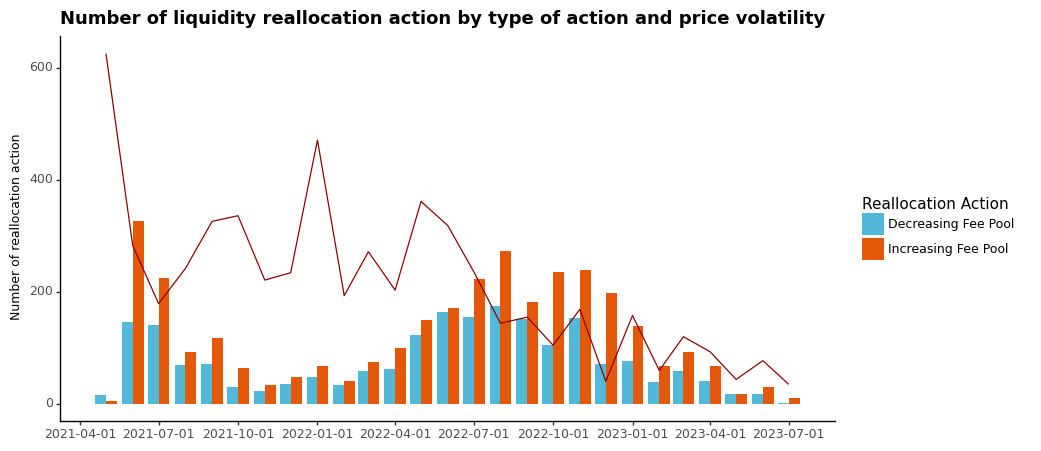

In [11]:
#liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month'])[['Increase Fee Count','Decrease Fee Count']].sum().melt(var_name = 'Reallocation Action', value_name = 'count', ignore_index = False).reset_index()
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month','Reallocation Action'])['SENDER'].count().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'SENDER', fill = 'Reallocation Action'), position = 'dodge') + 
    geom_line(aes(y = 'price'), color = 'darkred') +

    scale_fill_manual(values = ['#52b9d8','#e55709']) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5),
          legend_text = element_text(size = 9)) +
    labs(title = 'Number of liquidity reallocation action by type of action and price volatility',
         x = '', y = 'Number of reallocation action')
)

fig.save('./Plots/Number of liquidity reallocation action by type of action and price volatility', dpi = 1000)

print(fig)

### By Volume in USD

Since liquidity providers might not provide the same amount of token they withdrew into the pool again, we take the average of the two values as mean volume.

In [12]:
liquidity_reallocation['USD_mean'] = (np.abs(liquidity_reallocation[['Decreased Liquidity Token0 USD','Decreased Liquidity Token1 USD']].sum(axis = 1)) +\
                                      liquidity_reallocation[['Increased Liquidity Token0 USD','Increased Liquidity Token1 USD']].sum(axis = 1))/2

liquidity_reallocation[['SENDER','month','USD_mean']].head()

,SENDER,month,USD_mean
0,0x00000000002108f4085d2fd429669ce8f9851241,2022-09-01,23038.746183
1,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-09-01,12543.277612
2,0x0000c3caa36e2d9a8cd5269c976ede05018f0000,2022-10-01,15108.800548
3,0x000b85652fc321561cdf2bcadb07b61d8ab9ab8d,2022-08-01,3431.813091
4,0x0027a46efb18a6d72f113f8ebf4328ad65df22fa,2021-06-01,2410.322915


/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Volume of liquidity reallocation action


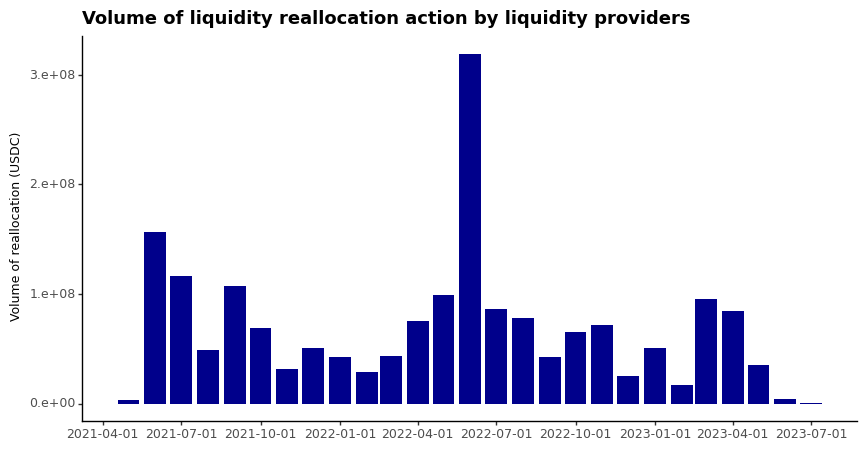

In [13]:
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month'])['USD_mean'].sum().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'USD_mean'), fill = 'darkblue') + 

    scale_y_continuous(labels = scientific_format(digits = 2)) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Volume of liquidity reallocation action by liquidity providers',
         x = '', y = 'Volume of reallocation (USDC)')
)

fig.save('./Plots/Volume of liquidity reallocation action', dpi = 1000)

print(fig)

We can see that by volume, the reallocation volume peaks at June 2022.

With volume, we also want to explore the volume of decreasing/increasing pool fees.

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Volume of liquidity reallocation action by type of action


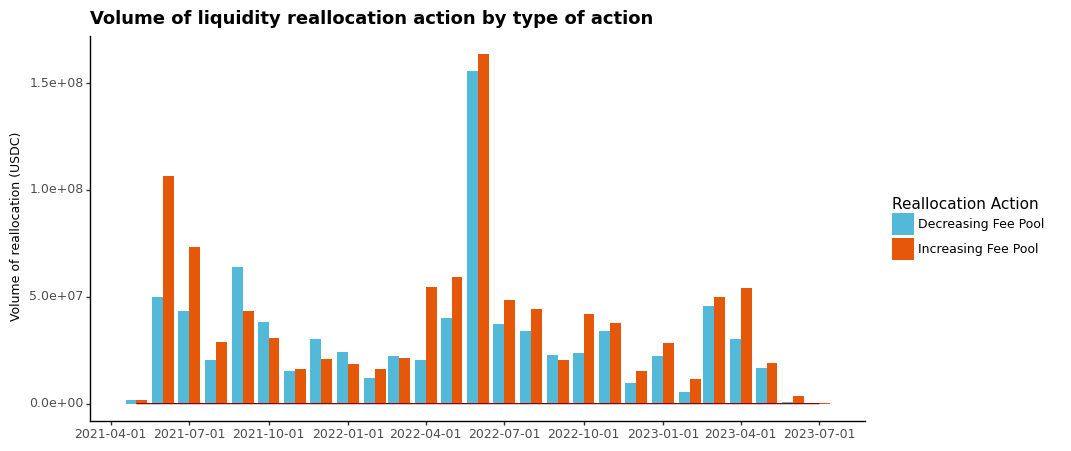

In [14]:
liquidity_reallocation_by_month = liquidity_reallocation.groupby(['month','Reallocation Action'])['USD_mean'].sum().reset_index()
liquidity_reallocation_by_month = liquidity_reallocation_by_month.merge(price_volatility, how = 'inner', on = 'month')

fig = (
ggplot(liquidity_reallocation_by_month, aes(x = 'month')) + 
    geom_col(aes(y = 'USD_mean', fill = 'Reallocation Action'), position = 'dodge') + 
    geom_line(aes(y = 'price'), color = 'darkred') +

    scale_y_continuous(labels = scientific_format(digits = 2)) +
    scale_fill_manual(values = ['#52b9d8','#e55709']) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5),
          legend_text = element_text(size = 9)) +
    labs(title = 'Volume of liquidity reallocation action by type of action',
         x = '', y = 'Volume of reallocation (USDC)')
)

fig.save('./Plots/Volume of liquidity reallocation action by type of action', dpi = 1000)

print(fig)

It is surprising that volume of LP increasing pool fees is similar to volume of decreasing pool fees in June 2022. We will split these into seperate cases during analysis.

### By Day

We also want to look close to by day of June 2022 to see exactly what happened.

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Number of liquidity provider that reallocated range of liquidity provision in June 2022


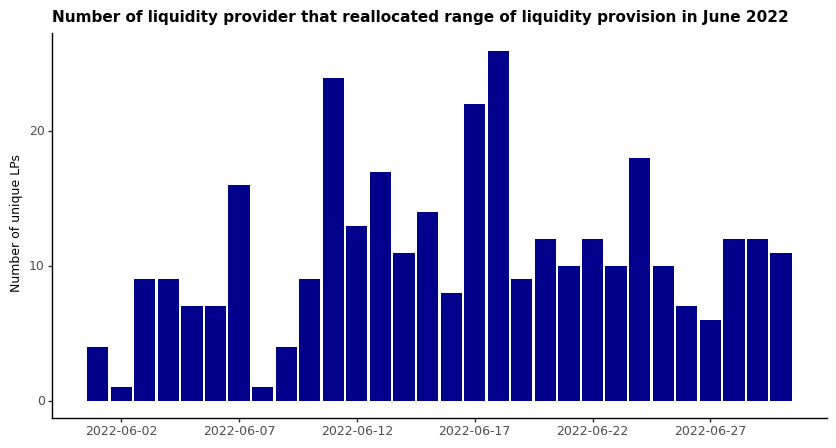

In [15]:
liquidity_reallocation_jun2022 = liquidity_reallocation[(liquidity_reallocation['Decreased Liquidity Timestamp'] >= dt.datetime(2022,6,1)) &\
                                                        (liquidity_reallocation['Increased Liquidity Timestamp'] < dt.datetime(2022,7,1))].copy()
liquidity_reallocation_jun2022['date'] = liquidity_reallocation_jun2022['Decreased Liquidity Timestamp'].dt.date
liquidity_reallocation_jun2022 = liquidity_reallocation_jun2022.groupby(['date'])['SENDER'].count().reset_index()

fig = (
ggplot(liquidity_reallocation_jun2022, aes(x = 'date')) + 
    geom_col(aes(y = 'SENDER'), fill = 'darkblue') + 

    scale_x_datetime(breaks = date_breaks('5 days')) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 11, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5)) +
    labs(title = 'Number of liquidity provider that reallocated range of liquidity provision in June 2022',
         x = '', y = 'Number of unique LPs')
)

fig.save('./Plots/Number of liquidity provider that reallocated range of liquidity provision in June 2022', dpi = 1000)

print(fig)

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 10 x 5 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Volume of liquidity reallocation action by type of action in June 2022


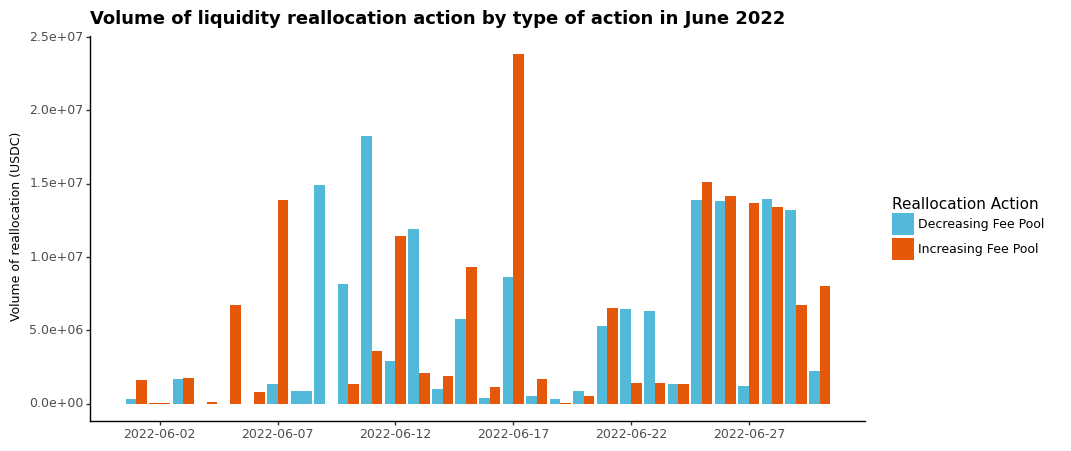

In [16]:
liquidity_reallocation_jun2022 = liquidity_reallocation[(liquidity_reallocation['Decreased Liquidity Timestamp'] >= dt.datetime(2022,6,1)) &\
                                                        (liquidity_reallocation['Increased Liquidity Timestamp'] < dt.datetime(2022,7,1))].copy()
liquidity_reallocation_jun2022['date'] = liquidity_reallocation_jun2022['Decreased Liquidity Timestamp'].dt.date
liquidity_reallocation_jun2022 = liquidity_reallocation_jun2022.groupby(['date','Reallocation Action'])['USD_mean'].sum().reset_index()

fig = (
ggplot(liquidity_reallocation_jun2022, aes(x = 'date')) + 
    geom_col(aes(y = 'USD_mean', fill = 'Reallocation Action'), position = 'dodge') + 

    scale_x_datetime(breaks = date_breaks('5 days')) +
    scale_y_continuous(labels = scientific_format(digits = 2)) +
    scale_fill_manual(values = ['#52b9d8','#e55709']) +
    
    theme_classic() +
    theme(plot_title = element_text(size = 13, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 9),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 9),
          figure_size = (10,5),
          legend_text = element_text(size = 9)) +
    labs(title = 'Volume of liquidity reallocation action by type of action in June 2022',
         x = '', y = 'Volume of reallocation (USDC)')
)

fig.save('./Plots/Volume of liquidity reallocation action by type of action in June 2022', dpi = 1000)

print(fig)

We do not observe any significant pattern.

### Individual LPs

We use this section to investigate the actions of individual. In particular, we want to look at the LPs that did the most asset reallocation (this might not be the largest LP but will be the most active one).

In [17]:
individual_LPs = liquidity_reallocation.groupby(['SENDER']).agg({'USD_mean':np.sum}).reset_index()
individual_LPs = individual_LPs.sort_values(by = 'USD_mean', ascending = False)
individual_LPs.head()

,SENDER,USD_mean
1899,0xb587606ca8ce0b7aa9d978b9c2308610644c6526,1.575526e+08
159,0x1111567e0954e74f6ba7c4732d534e75b81dc42e,9.278639e+07
1196,0x741aa7cfb2c7bf2a1e7d4da2e3df6a56ca4131f3,7.591372e+07
1183,0x72a916702bd97923e55d78ea5a3f413dec7f7f85,6.870521e+07
274,0x1b272cbd2ae16192bcb748797a06b28f8b8539fa,6.453487e+07


For these top LPs, we are interested in how their liquidity provision between different fees pool change over time.

To remove the effect of impermanent loss and change in token prices in the primary exchange, we set withdraw amount (in USD) to be relative to deposit amount (in USD) based on the Liquidity Parameter. For example, if a LP chooses to remove half of the Liquidity Parameter, this is reflected as a liquidity withdrawal of half of the USD value of his initial withdrawal. This give us a sense of how much each LP chooses to deposit their liquidity in pools of different fees, regardless of impermanent loss.

In [18]:
n = 9
individual_LPs_allocation = lp_action[lp_action['SENDER'].isin(individual_LPs['SENDER'].iloc[0:n])].copy()
individual_LPs_allocation['USD_mean'] = individual_LPs_allocation['AMOUNT0_USD'] + individual_LPs_allocation['AMOUNT1_USD']
individual_LPs_allocation = individual_LPs_allocation.sort_values(by = ['SENDER','NF_TOKEN_ID','BLOCK_NUMBER'])
individual_LPs_allocation.reset_index(drop = True, inplace = True)

# Structuring liquidity withdrawal
individual_LPs_allocation['Remaining L'] = individual_LPs_allocation.groupby(['SENDER','NF_TOKEN_ID'])['L'].cumsum()

for i in range(len(individual_LPs_allocation)):

    if individual_LPs_allocation.loc[i,'EVENT_NAME'] == 'Decrease Liquidity':

        temp = individual_LPs_allocation[(individual_LPs_allocation['SENDER'] == individual_LPs_allocation.loc[i,'SENDER']) & (individual_LPs_allocation['NF_TOKEN_ID'] == individual_LPs_allocation.loc[i,'NF_TOKEN_ID']) &
                                         (individual_LPs_allocation.index < i)]
        remaining_USD_mean = temp['USD_mean'].sum()

        individual_LPs_allocation.loc[i,'USD_mean'] = np.abs(individual_LPs_allocation.loc[i,'L'])/individual_LPs_allocation.loc[i-1,'Remaining L']*remaining_USD_mean
    
    else: 
        continue

# Merge actions done in the same block (since it is atomic)
individual_LPs_allocation = individual_LPs_allocation.groupby(['SENDER','POOL_NAME','BLOCK_TIMESTAMP'])['USD_mean'].sum().reset_index()

# Pivot dataframe
top_LP_allocation = individual_LPs_allocation.pivot(index = 'BLOCK_TIMESTAMP', columns = ['SENDER','POOL_NAME'], values = 'USD_mean')
top_LP_allocation.fillna(0, inplace = True)
top_LP_allocation = top_LP_allocation.apply(np.cumsum)

# Get percentages
top_LP_allocation = top_LP_allocation.div(top_LP_allocation.groupby(level = 0, axis = 1).sum(), level = 0)
top_LP_allocation.fillna(0, inplace = True)

# Filter for June 2022
#top_LP_allocation = top_LP_allocation[(top_LP_allocation.index >= dt.datetime(2022,6,1)) & (top_LP_allocation.index < dt.datetime(2022,7,1))]

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 16 x 8 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Plots/Distribution of liquidity provided in different fee pools by top liquidity provider.png


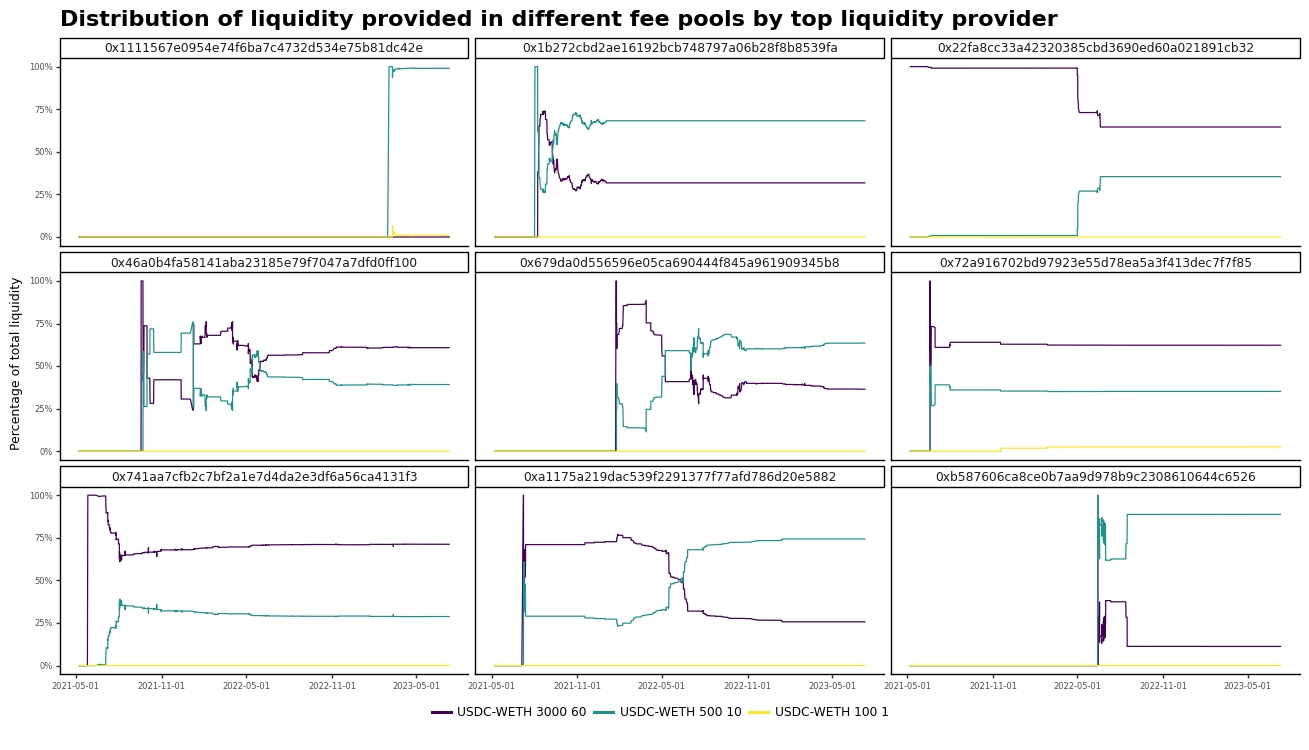

In [19]:
fig = (
ggplot(top_LP_allocation.unstack(level = 1).reset_index(name = 'perc'), aes(x = 'BLOCK_TIMESTAMP', y = 'perc')) +
    
    geom_line(aes(color = 'POOL_NAME')) + 

    facet_wrap('SENDER') +
    
    scale_x_datetime(breaks = date_breaks('6 months')) +
    scale_y_continuous(labels = percent_format()) +
    
    theme_classic() + 
    theme(plot_title = element_text(size = 16, face = 'bold', ha = 'left'),
          axis_title_x = element_text(size = 9),
          axis_text_x = element_text(size = 6),
          axis_title_y = element_text(size = 9),
          axis_text_y = element_text(size = 6),
          legend_position = 'bottom',
          legend_title = element_blank(),
          figure_size = (16,8)) +
    labs(title = 'Distribution of liquidity provided in different fee pools by top liquidity provider',
         x = '', y = 'Percentage of total liquidity')
)

fig.save('./Plots/Distribution of liquidity provided in different fee pools by top liquidity provider.png', dpi = 1000)

print(fig)